**Autor:** [Lucas Lima](https://github.com/lucasouzamil)

# **Análise do Conjunto de Dados de Avaliação de Detecção de Intrusões (CIC-IDS2017)**

Este documento tem como propósito apresentar um resumo da [análise conduzida por Noushin Pervez](https://github.com/noushinpervez/Intrusion-Detection-CICIDS2017), na qual a autora explora e compara diferentes modelos de Machine Learning aplicados à detecção de intrusões, utilizando o [Conjunto de Dados CIC-IDS2017](https://www.unb.ca/cic/datasets/ids-2017.html), desenvolvido pelo Canadian Institute for Cybersecurity.

A proposta deste resumo é implementar, de forma objetiva e simplificada, os dois modelos considerados mais eficazes pela autora em sua análise, tanto para classificação binária quanto para classificação multiclasses, a fim de reproduzir os resultados em um código mais enxuto e direto. Para informações adicionais ou aprofundamento teórico, recomenda-se a consulta ao estudo original.

Este material serve como base para o desenvolvimento de um sistema automatizado capaz de identificar e classificar ameaças cibernéticas em servidores web, com base em dados reais de tráfego de rede.

Trata-se de uma iniciativa com fins exclusivamente educacionais.

## 1. Coleta dos dados

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

In [2]:
data1 = pd.read_csv('./data/Monday-WorkingHours.pcap_ISCX.csv')
data2 = pd.read_csv('./data/Tuesday-WorkingHours.pcap_ISCX.csv')
data3 = pd.read_csv('./data/Wednesday-workingHours.pcap_ISCX.csv')
data4 = pd.read_csv('./data/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
data5 = pd.read_csv('./data/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
data6 = pd.read_csv('./data/Friday-WorkingHours-Morning.pcap_ISCX.csv')
data7 = pd.read_csv('./data/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
data8 = pd.read_csv('./data/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

In [3]:
# Junção dos diferentes Datasets
data_list = [data1, data2, data3, data4, data5, data6, data7, data8]
data = pd.concat(data_list)

In [4]:
# Removendo datasets para poupar memória
for d in data_list: del d

In [5]:
# Renomeando as colunas para tirar espaços em branco
col_names = {col: col.strip() for col in data.columns}
data.rename(columns = col_names, inplace = True)

In [6]:
data.describe().transpose()

/home/borg/Área de Trabalho/techhack/Intrusion-Detection-CICIDS2017/.venv/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/borg/Área de Trabalho/techhack/Intrusion-Detection-CICIDS2017/.venv/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,count,mean,std,min,25%,50%,75%,max
Destination Port,2830743.0,8.071483e+03,1.828363e+04,0.0,53.0,80.0,443.0,65535.0
Flow Duration,2830743.0,1.478566e+07,3.365374e+07,-13.0,155.0,31316.0,3204828.5,119999998.0
Total Fwd Packets,2830743.0,9.361160e+00,7.496728e+02,1.0,2.0,2.0,5.0,219759.0
Total Backward Packets,2830743.0,1.039377e+01,9.973883e+02,0.0,1.0,2.0,4.0,291922.0
Total Length of Fwd Packets,2830743.0,5.493024e+02,9.993589e+03,0.0,12.0,62.0,187.0,12900000.0
...,...,...,...,...,...,...,...,...
Active Min,2830743.0,5.829582e+04,5.770923e+05,0.0,0.0,0.0,0.0,110000000.0
Idle Mean,2830743.0,8.316037e+06,2.363008e+07,0.0,0.0,0.0,0.0,120000000.0
Idle Std,2830743.0,5.038439e+05,4.602984e+06,0.0,0.0,0.0,0.0,76900000.0
Idle Max,2830743.0,8.695752e+06,2.436689e+07,0.0,0.0,0.0,0.0,120000000.0


## 2. Pré-processamento de Dados

In [7]:
# Removendo coluna dupplicada (Fwd Header Length e Fwd Header Length.1)
data.drop(columns=["Fwd Header Length.1"], inplace=True)

In [8]:
# Removendo linhas duplicadas (linhas iguais, todas features iguais)
data.drop_duplicates(inplace = True)

In [9]:
# Substituindo valores infinitos por NaN
data.replace([np.inf, -np.inf], np.nan, inplace = True)

In [10]:
# Corrigir colunas duplicadas (indices iguais)
data = data.loc[:, ~data.columns.duplicated()]

# Corrigir índice duplicado (transforma o índice em uma contagem sequencial (0, 1, 2, ...))
data = data.reset_index(drop=True)

In [11]:
# Identificando valores faltantes NaN
missing = data.isna().sum()
print(missing.loc[missing > 0])

Flow Bytes/s      1564
Flow Packets/s    1564
dtype: int64


In [12]:
# Substituindo valores faltantes NaN pela mediana ()
med_flow_bytes = data['Flow Bytes/s'].median()
med_flow_packets = data['Flow Packets/s'].median()

data['Flow Bytes/s'] = data['Flow Bytes/s'].fillna(med_flow_bytes)
data['Flow Packets/s'] = data['Flow Packets/s'].fillna(med_flow_packets)

In [13]:
# Dropando colunas que não alteram o valor
num_unique = data.nunique()
one_variable = num_unique[num_unique == 1]
not_one_variable = num_unique[num_unique > 1].index

dropped_cols = one_variable.index
data = data[not_one_variable]

print('Colunas Dropadas:')
dropped_cols

Colunas Dropadas:


Index(['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk',
       'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk',
       'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'],
      dtype='object')

In [14]:
# Criando um dicionario que mapeia cada label para seu tipo de ataque
attack_map = {
    'BENIGN': 'BENIGN',
    'DDoS': 'DDoS',
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'PortScan': 'Port Scan',
    'FTP-Patator': 'Brute Force',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bot',
    'Web Attack � Brute Force': 'Web Attack',
    'Web Attack � XSS': 'Web Attack',
    'Web Attack � Sql Injection': 'Web Attack',
    'Infiltration': 'Infiltration',
    'Heartbleed': 'Heartbleed'
}

# Criando uma nova coluna no DataBase usando o dicionario attack_map
data['Attack Type'] = data['Label'].map(attack_map)

In [15]:
#Dropando coluna antiga
data.drop('Label', axis = 1, inplace = True)

In [16]:
feature_order = [col for col in list(data.columns) if col != "Attack Type"]
data_prepro = data
data.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count',

### Ajuste necessario para a ordem e grandezas ficarem iguais aos do CIC csv python

In [ ]:


# ------------------------------------------------------------------
# 1  Renomeia todos os campos para a grafia usada pelo CICFlowMeter-Python
# ------------------------------------------------------------------
rename_map = {
    # portas e contagens ------------------------------------------------------
    "Destination Port"            : "dst_port",
    "Total Fwd Packets"           : "tot_fwd_pkts",
    "Total Backward Packets"      : "tot_bwd_pkts",
    "Total Length of Fwd Packets" : "totlen_fwd_pkts",
    "Total Length of Bwd Packets" : "totlen_bwd_pkts",

    # tamanhos de pacotes -----------------------------------------------------
    "Fwd Packet Length Max"  : "fwd_pkt_len_max",
    "Fwd Packet Length Min"  : "fwd_pkt_len_min",
    "Fwd Packet Length Mean" : "fwd_pkt_len_mean",
    "Fwd Packet Length Std"  : "fwd_pkt_len_std",
    "Bwd Packet Length Max"  : "bwd_pkt_len_max",
    "Bwd Packet Length Min"  : "bwd_pkt_len_min",
    "Bwd Packet Length Mean" : "bwd_pkt_len_mean",
    "Bwd Packet Length Std"  : "bwd_pkt_len_std",

    # estatísticas de fluxo ----------------------------------------------------
    "Flow Duration"   : "flow_duration",
    "Flow Bytes/s"    : "flow_byts_s",
    "Flow Packets/s"  : "flow_pkts_s",

    # IAT (tempos entre pacotes) ----------------------------------------------
    "Flow IAT Mean" : "flow_iat_mean",
    "Flow IAT Std"  : "flow_iat_std",
    "Flow IAT Max"  : "flow_iat_max",
    "Flow IAT Min"  : "flow_iat_min",

    "Fwd IAT Total" : "fwd_iat_tot",
    "Fwd IAT Mean"  : "fwd_iat_mean",
    "Fwd IAT Std"   : "fwd_iat_std",
    "Fwd IAT Max"   : "fwd_iat_max",
    "Fwd IAT Min"   : "fwd_iat_min",

    "Bwd IAT Total" : "bwd_iat_tot",
    "Bwd IAT Mean"  : "bwd_iat_mean",
    "Bwd IAT Std"   : "bwd_iat_std",
    "Bwd IAT Max"   : "bwd_iat_max",
    "Bwd IAT Min"   : "bwd_iat_min",

    # cabeçalhos e taxas de pacotes -------------------------------------------
    "Fwd Header Length" : "fwd_header_len",
    "Bwd Header Length" : "bwd_header_len",
    "Fwd Packets/s"     : "fwd_pkts_s",
    "Bwd Packets/s"     : "bwd_pkts_s",

    # comprimento de pacotes agregados ----------------------------------------
    "Min Packet Length"     : "pkt_len_min",
    "Max Packet Length"     : "pkt_len_max",
    "Packet Length Mean"    : "pkt_len_mean",
    "Packet Length Std"     : "pkt_len_std",
    "Packet Length Variance": "pkt_len_var",

    # flags -------------------------------------------------------------------
    "FIN Flag Count" : "fin_flag_cnt",
    "SYN Flag Count" : "syn_flag_cnt",
    "RST Flag Count" : "rst_flag_cnt",
    "PSH Flag Count" : "psh_flag_cnt",
    "ACK Flag Count" : "ack_flag_cnt",
    "URG Flag Count" : "urg_flag_cnt",
    "Fwd PSH Flags"  : "fwd_psh_flags",
    "Fwd URG Flags"  : "fwd_urg_flags",
    "CWE Flag Count" : "cwr_flag_count",   # CWR no csv Python
    "ECE Flag Count" : "ece_flag_cnt",

    # métricas de taxa e proporção --------------------------------------------
    "Down/Up Ratio"       : "down_up_ratio",
    "Average Packet Size" : "pkt_size_avg",

    # segmentos ----------------------------------------------------------------
    "Avg Fwd Segment Size" : "fwd_seg_size_avg",
    "Avg Bwd Segment Size" : "bwd_seg_size_avg",
    "min_seg_size_forward" : "fwd_seg_size_min",
    "act_data_pkt_fwd"     : "fwd_act_data_pkts",

    # sub-fluxos ---------------------------------------------------------------
    "Subflow Fwd Packets" : "subflow_fwd_pkts",
    "Subflow Fwd Bytes"   : "subflow_fwd_byts",
    "Subflow Bwd Packets" : "subflow_bwd_pkts",
    "Subflow Bwd Bytes"   : "subflow_bwd_byts",

    # janela TCP ---------------------------------------------------------------
    "Init_Win_bytes_forward"  : "init_fwd_win_byts",
    "Init_Win_bytes_backward" : "init_bwd_win_byts",

    # tempos de atividade/ociosidade ------------------------------------------
    "Active Mean" : "active_mean",
    "Active Std"  : "active_std",
    "Active Max"  : "active_max",
    "Active Min"  : "active_min",
    "Idle Mean"   : "idle_mean",
    "Idle Std"    : "idle_std",
    "Idle Max"    : "idle_max",
    "Idle Min"    : "idle_min",
}

data.rename(columns=rename_map, inplace=True)

# ------------------------------------------------------------------
# 2  Converte TODAS as colunas de tempo de μs → s (unidade usada pelo CIC-Python)
# ------------------------------------------------------------------
time_cols = [
    "flow_duration",
    "flow_iat_mean", "flow_iat_std", "flow_iat_max", "flow_iat_min",
    "fwd_iat_tot", "fwd_iat_mean", "fwd_iat_std", "fwd_iat_max", "fwd_iat_min",
    "bwd_iat_tot", "bwd_iat_mean", "bwd_iat_std", "bwd_iat_max", "bwd_iat_min",
    "active_max", "active_min", "active_mean", "active_std",
    "idle_max", "idle_min", "idle_mean", "idle_std",
]

# converte apenas as colunas que realmente existem no DataFrame
present_time_cols = [c for c in time_cols if c in data.columns]
data[present_time_cols] = data[present_time_cols] / 1_000_000.0

# ------------------------------------------------------------------
# 3  Define a ordem definitiva dos atributos (CIC-Python) + alvo
# ------------------------------------------------------------------
cic_python_order = [
    "dst_port", "flow_duration",
    "flow_byts_s", "flow_pkts_s", "fwd_pkts_s", "bwd_pkts_s",

    "tot_fwd_pkts", "tot_bwd_pkts",
    "totlen_fwd_pkts", "totlen_bwd_pkts",

    "fwd_pkt_len_max", "fwd_pkt_len_min", "fwd_pkt_len_mean", "fwd_pkt_len_std",
    "bwd_pkt_len_max", "bwd_pkt_len_min", "bwd_pkt_len_mean", "bwd_pkt_len_std",

    "pkt_len_max", "pkt_len_min", "pkt_len_mean", "pkt_len_std", "pkt_len_var",

    "fwd_header_len", "bwd_header_len",
    "fwd_seg_size_min", "fwd_act_data_pkts",

    "flow_iat_mean", "flow_iat_max", "flow_iat_min", "flow_iat_std",
    "fwd_iat_tot", "fwd_iat_max", "fwd_iat_min", "fwd_iat_mean", "fwd_iat_std",
    "bwd_iat_tot", "bwd_iat_max", "bwd_iat_min", "bwd_iat_mean", "bwd_iat_std",

    "fwd_psh_flags", "bwd_psh_flags", "fwd_urg_flags", "bwd_urg_flags",
    "fin_flag_cnt", "syn_flag_cnt", "rst_flag_cnt",
    "psh_flag_cnt", "ack_flag_cnt", "urg_flag_cnt",
    "ece_flag_cnt",                       # idem CSV
    "down_up_ratio", "pkt_size_avg",

    "init_fwd_win_byts", "init_bwd_win_byts",

    "active_max", "active_min", "active_mean", "active_std",
    "idle_max",   "idle_min",   "idle_mean",   "idle_std",

    "fwd_seg_size_avg", "bwd_seg_size_avg",
    "cwr_flag_count",

    "subflow_fwd_pkts", "subflow_bwd_pkts",
    "subflow_fwd_byts", "subflow_bwd_byts",

    "Attack Type",
]

# mantém apenas as colunas realmente presentes e na ordem desejada
cic_python_order = [c for c in cic_python_order if c in data.columns] + ["Attack Type"]
data = data[cic_python_order]
data.head(10)


,dst_port,flow_duration,flow_byts_s,flow_pkts_s,fwd_pkts_s,bwd_pkts_s,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,...,idle_std,fwd_seg_size_avg,bwd_seg_size_avg,cwr_flag_count,subflow_fwd_pkts,subflow_bwd_pkts,subflow_fwd_byts,subflow_bwd_byts,Attack Type,Attack Type
0,49188,0.000004,3.000000e+06,5.000000e+05,5.000000e+05,0.000000,2,0,12,0,...,0.0,6.000000,0.0,0,2,0,12,0,BENIGN,BENIGN
1,49188,0.000001,1.200000e+07,2.000000e+06,2.000000e+06,0.000000,2,0,12,0,...,0.0,6.000000,0.0,0,2,0,12,0,BENIGN,BENIGN
2,49486,0.000003,4.000000e+06,6.666667e+05,6.666667e+05,0.000000,2,0,12,0,...,0.0,6.000000,0.0,0,2,0,12,0,BENIGN,BENIGN
3,49486,0.000001,1.200000e+07,2.000000e+06,2.000000e+06,0.000000,2,0,12,0,...,0.0,6.000000,0.0,0,2,0,12,0,BENIGN,BENIGN
4,88,0.000609,1.474548e+06,1.806240e+04,1.149425e+04,6568.144499,7,4,484,414,...,0.0,69.142857,103.5,0,7,4,484,414,BENIGN,BENIGN
5,88,0.000879,4.232082e+06,1.478953e+04,1.023891e+04,4550.625711,9,4,656,3064,...,0.0,72.888889,766.0,0,9,4,656,3064,BENIGN,BENIGN
6,88,0.001160,5.329310e+06,1.293103e+04,7.758621e+03,5172.413793,9,6,3134,3048,...,0.0,348.222222,508.0,0,9,6,3134,3048,BENIGN,BENIGN
7,88,0.000524,1.074809e+07,2.099237e+04,1.335878e+04,7633.587786,7,4,2812,2820,...,0.0,401.714286,705.0,0,7,4,2812,2820,BENIGN,BENIGN
8,1034,0.000006,2.000000e+06,3.333333e+05,1.666667e+05,166666.666667,1,1,6,6,...,0.0,6.000000,6.0,0,1,1,6,6,BENIGN,BENIGN
9,88,0.001119,5.558534e+06,1.340483e+04,8.042895e+03,5361.930295,9,6,3160,3060,...,0.0,351.111111,510.0,0,9,6,3160,3060,BENIGN,BENIGN


In [18]:
#salvando dados formatados
data_prepro.to_csv("data/data_prepro.csv", index=False)
import json
json.dump(list(feature_order), open("modelos/feature_order.json", "w"))



In [19]:
# Salva uma demo com apenas 20 amostras
data.sample(n=20, random_state=42).to_csv("data/demo_prepro.csv", index=False)

### Inicio da Pipeline

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

In [21]:
data = pd.read_csv("./data/data_prepro.csv")

In [22]:
data.head(10)

,dst_port,flow_duration,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_mean,fwd_pkt_len_std,...,fwd_seg_size_min,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,Attack Type
0,49188,0.000004,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,49188,0.000001,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,49486,0.000003,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,49486,0.000001,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,88,0.000609,7,4,484,414,233,0,69.142857,111.967895,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
5,88,0.000879,9,4,656,3064,313,0,72.888889,136.153814,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
6,88,0.001160,9,6,3134,3048,1552,0,348.222222,682.482560,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
7,88,0.000524,7,4,2812,2820,1397,0,401.714286,679.914876,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
8,1034,0.000006,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
9,88,0.001119,9,6,3160,3060,1565,0,351.111111,688.214982,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [23]:
# Padronizando o dataset
from sklearn.preprocessing import StandardScaler

features = data.drop('Attack Type', axis = 1)
attacks = data['Attack Type']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [24]:
from sklearn.decomposition import IncrementalPCA

size = len(features.columns) // 2
ipca = IncrementalPCA(n_components = size, batch_size = 500)
for batch in np.array_split(scaled_features, len(features) // 500):
  ipca.partial_fit(batch)

print(f'information retained: {sum(ipca.explained_variance_ratio_):.2%}')

information retained: 99.14%


In [25]:
transformed_features = ipca.transform(scaled_features)
new_data = pd.DataFrame(transformed_features, columns = [f'PC{i+1}' for i in range(size)])
new_data['Attack Type'] = attacks.values

In [26]:
new_data

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,Attack Type
0,-2.357610,-0.054983,0.577384,0.734506,3.730427,0.234159,-0.215793,-0.277628,1.087729,0.032701,...,0.869394,-0.146296,-0.329932,1.490254,-0.195626,-0.184648,-0.004574,-0.001592,-0.029062,BENIGN
1,-2.883860,-0.069942,0.911339,1.763264,8.846304,0.619105,1.097237,1.912731,-2.755940,-0.950218,...,0.676611,0.279366,-2.342387,2.244380,-0.700029,-0.233638,0.007405,-0.002481,-0.049547,BENIGN
2,-2.416933,-0.056686,0.615353,0.850929,4.304282,0.275193,-0.071753,-0.033827,0.664627,-0.076140,...,0.845967,-0.100562,-0.541068,1.574828,-0.248754,-0.189357,-0.003384,-0.001704,-0.031074,BENIGN
3,-2.884710,-0.069983,0.912201,1.765380,8.851728,0.617367,1.095385,1.913159,-2.751966,-0.949845,...,0.674604,0.277804,-2.329917,2.245163,-0.697112,-0.232903,0.007263,-0.002495,-0.049284,BENIGN
4,-1.505248,0.080885,-0.504384,0.290438,-0.539280,0.746382,0.739116,-1.145780,-0.562622,-0.043700,...,-0.703462,-0.598198,0.118951,0.795409,-0.200681,0.076863,-0.014480,0.004399,0.053137,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2522357,-2.270965,-0.048463,0.479996,0.461167,2.163945,-0.144811,-0.775629,-0.909008,2.711450,0.413677,...,0.736106,-0.040314,0.788980,0.784337,0.254411,0.000468,-0.016897,-0.000921,-0.008129,BENIGN
2522358,-2.267921,-0.048378,0.478567,0.457931,2.144129,-0.146827,-0.778422,-0.912163,2.718095,0.416247,...,0.732148,-0.038382,0.790335,0.785675,0.256042,0.002105,-0.017046,-0.000889,-0.007579,BENIGN
2522359,-2.267235,-0.048360,0.478245,0.457180,2.139667,-0.147267,-0.779036,-0.912852,2.719524,0.416812,...,0.731248,-0.037950,0.790475,0.785978,0.256355,0.002453,-0.017077,-0.000882,-0.007458,BENIGN
2522360,-2.102461,-0.041901,0.361542,0.268758,1.795840,0.284602,-0.294249,-0.631516,0.967058,0.081959,...,0.246504,-0.368728,1.793026,-0.927839,0.316733,0.070898,-0.004614,0.002837,0.056074,BENIGN


## 3. Modelos de	Machine Learning

In [27]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

### Classificação Multiclasse (Random Forest)

In [28]:
new_data['Attack Type'].value_counts()

Attack Type
BENIGN          2096484
DoS              193748
DDoS             128016
Port Scan         90819
Brute Force        9152
Web Attack         2143
Bot                1953
Infiltration         36
Heartbleed           11
Name: count, dtype: int64

In [29]:
class_counts = new_data['Attack Type'].value_counts()
selected_classes = class_counts[class_counts > 1950]
class_names = selected_classes.index
selected = new_data[new_data['Attack Type'].isin(class_names)]

dfs = []
for name in class_names:
  df = selected[selected['Attack Type'] == name]
  if len(df) > 2500:
    df = df.sample(n = 5000, random_state = 0)

  dfs.append(df)

df = pd.concat(dfs, ignore_index = True)
df['Attack Type'].value_counts()

Attack Type
BENIGN         5000
DoS            5000
DDoS           5000
Port Scan      5000
Brute Force    5000
Web Attack     2143
Bot            1953
Name: count, dtype: int64

In [30]:
from imblearn.over_sampling import SMOTE

X = df.drop('Attack Type', axis=1)
y = df['Attack Type']

smote = SMOTE(sampling_strategy='auto', random_state=0)
X_upsampled, y_upsampled = smote.fit_resample(X, y)

blnc_data = pd.DataFrame(X_upsampled)
blnc_data['Attack Type'] = y_upsampled
blnc_data = blnc_data.sample(frac=1)

blnc_data['Attack Type'].value_counts()

Attack Type
DoS            5000
Brute Force    5000
DDoS           5000
Web Attack     5000
BENIGN         5000
Port Scan      5000
Bot            5000
Name: count, dtype: int64

In [31]:
from sklearn.model_selection import train_test_split

features = blnc_data.drop('Attack Type', axis = 1)
labels = blnc_data['Attack Type']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 0)

In [32]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 15, max_depth = 8, max_features = 20, random_state = 0)
rf.fit(X_train, y_train)

cv_rf = cross_val_score(rf, X_train, y_train, cv = 5)
print('Random Forest Model 2')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_rf)))
print(f'\nMean cross-validation score: {cv_rf.mean():.2f}')

Random Forest Model 2

Cross-validation scores: 0.9843809523809524, 0.9798095238095238, 0.9811428571428571, 0.9794285714285714, 0.981904761904762

Mean cross-validation score: 0.98


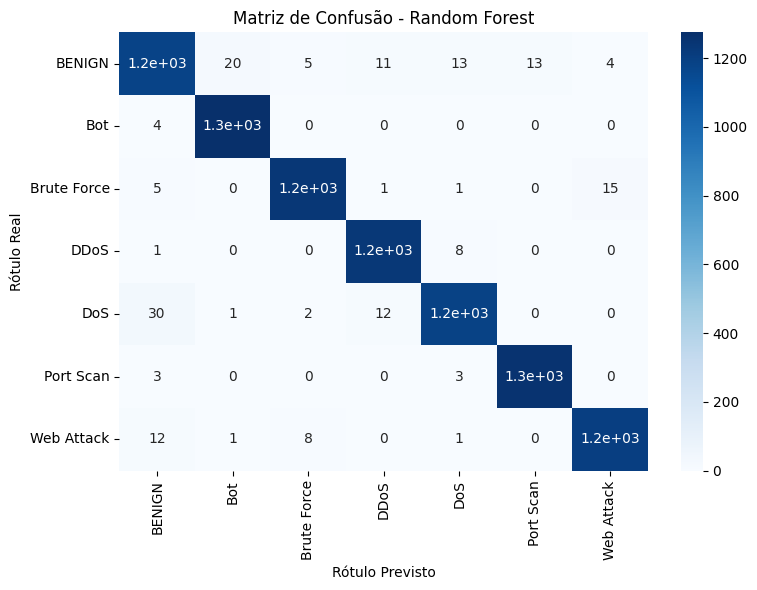

In [33]:
y_pred_rf = rf.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title('Matriz de Confusão - Random Forest')
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Real')
plt.tight_layout()
plt.show()

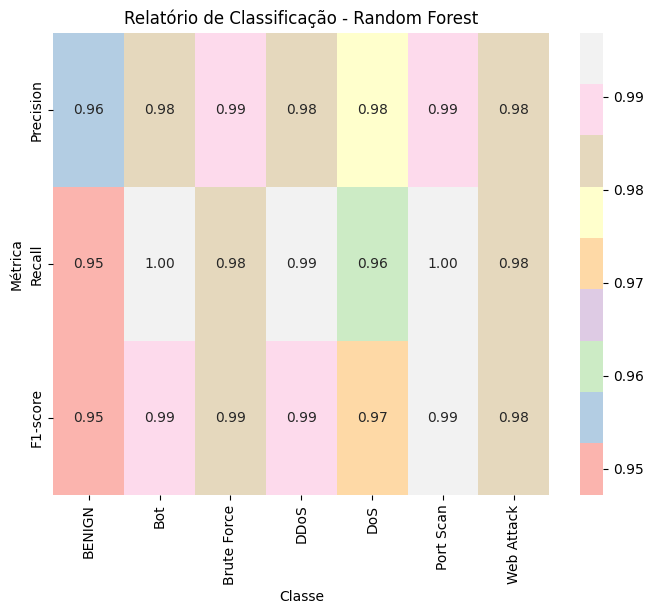

In [34]:
target_names = rf.classes_
metrics = classification_report(y_true=y_test, y_pred=y_pred_rf, target_names=target_names, output_dict=True)

precision = [metrics[target]['precision'] for target in target_names]
recall = [metrics[target]['recall'] for target in target_names]
f1 = [metrics[target]['f1-score'] for target in target_names]

data = [precision, recall, f1]
rows = ['Precision', 'Recall', 'F1-score']

plt.figure(figsize=(8, 6))
sns.heatmap(data, cmap='Pastel1', annot=True, fmt='.2f', xticklabels=target_names, yticklabels=rows)
plt.title('Relatório de Classificação - Random Forest')
plt.xlabel('Classe')
plt.ylabel('Métrica')
plt.show()